In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import dask
import scipy
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import os
import skimage

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import MapboxTiles
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore")

import imageio
import geojson
import requests

from launches import *

from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import font_manager as fm

%matplotlib inline

In [6]:
# 1) Register your new fonts explicitly
font_dir = os.path.expanduser("~/.local/share/fonts")
for path in glob.glob(os.path.join(font_dir, "lm*.otf")):
    fm.fontManager.addfont(path)
for path in glob.glob(os.path.join(font_dir, "cmu*.otf")):
    fm.fontManager.addfont(path)
# Global LaTeX-y defaults
mpl.rcParams.update({
    "text.usetex": False,              # keep mathtext (no TeX required)
    "mathtext.fontset": "cm",          # Computer Modern math
    "axes.unicode_minus": False,

    # Default family = serif (like LaTeX)
    "font.family": "serif",

    # Families mapped to your installed fonts (with sensible fallbacks)
    "font.serif": ["LMRoman10", "CMU Serif", "DejaVu Serif"],
    "font.sans-serif": ["LMSans10", "CMU Sans Serif", "DejaVu Sans"],
    "font.monospace": ["LMMono10", "CMU Typewriter Text", "DejaVu Sans Mono"],
})


### Load Data

In [7]:
initial_detections_df = pd.read_csv('data/initial_detections.csv',)
initial_detections_df['timestamp'] = pd.to_datetime(initial_detections_df['Launch_JD'], unit='D', origin='julian')

### Detection rate

In [9]:
###
# Load launch vehicle database and convert numeric columns
lv_df = pd.read_csv("https://planet4589.org/space/gcat/tsv/tables/lv.tsv", sep="\t")
# Clean numeric columns 
numeric_cols = ['LV_Min_Stage', 'LV_Max_Stage']
lv_df[numeric_cols] = lv_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
# Clean values that might be strings representing numbers
for col in ['Length', 'Diameter', 'Launch_Mass', 'LEO_Capacity', 'GTO_Capacity', 'TO_Thrust', 'Apogee', 'Range']:
    lv_df[col] = pd.to_numeric(lv_df[col].replace(['?', '-', ''], np.nan), errors='coerce')
# Drop the comment row that starts with #
lv_df = lv_df[~lv_df['#LV_Name'].str.contains('#', na=False)]


In [10]:
full_launch_df = get_launch_df()
merged_df = full_launch_df.merge(
    lv_df,
    left_on=['LV_Type', 'Variant'],
    right_on=['#LV_Name', 'LV_Variant'],
    how='left'
)

In [11]:
detection_rate_df = (
    full_launch_df.groupby('LV_Type')['Launch_JD'].nunique()
    .to_frame('total_launches')
    .assign(detections=initial_detections_df.drop_duplicates(subset='Launch_JD', keep='first').groupby('LV_Type')['Launch_JD'].nunique())
    .fillna(0)
    .assign(detection_rate=lambda df: df['detections'] / df['total_launches'])
    .reset_index()
)

In [12]:
detection_rate_df.replace(np.nan, 0, inplace=True)

In [14]:
# Merge Launch_Mass from lv_df
plot_df = detection_rate_df.merge(
    lv_df[['#LV_Name', 'Launch_Mass', 'Length']],
    left_on='LV_Type',
    right_on='#LV_Name',
    how='left'
)

plot_df = plot_df.groupby('LV_Type').agg(
    Launch_Mass=('Launch_Mass', 'mean'),
    Length=('Length', 'mean'),
    total_launches=('total_launches', 'mean'),
    detections=('detections', 'mean'),
    detection_rate=('detection_rate', 'mean')
).reset_index()

In [15]:
plot_df['detections'].sum()

30.0

# Figure S2

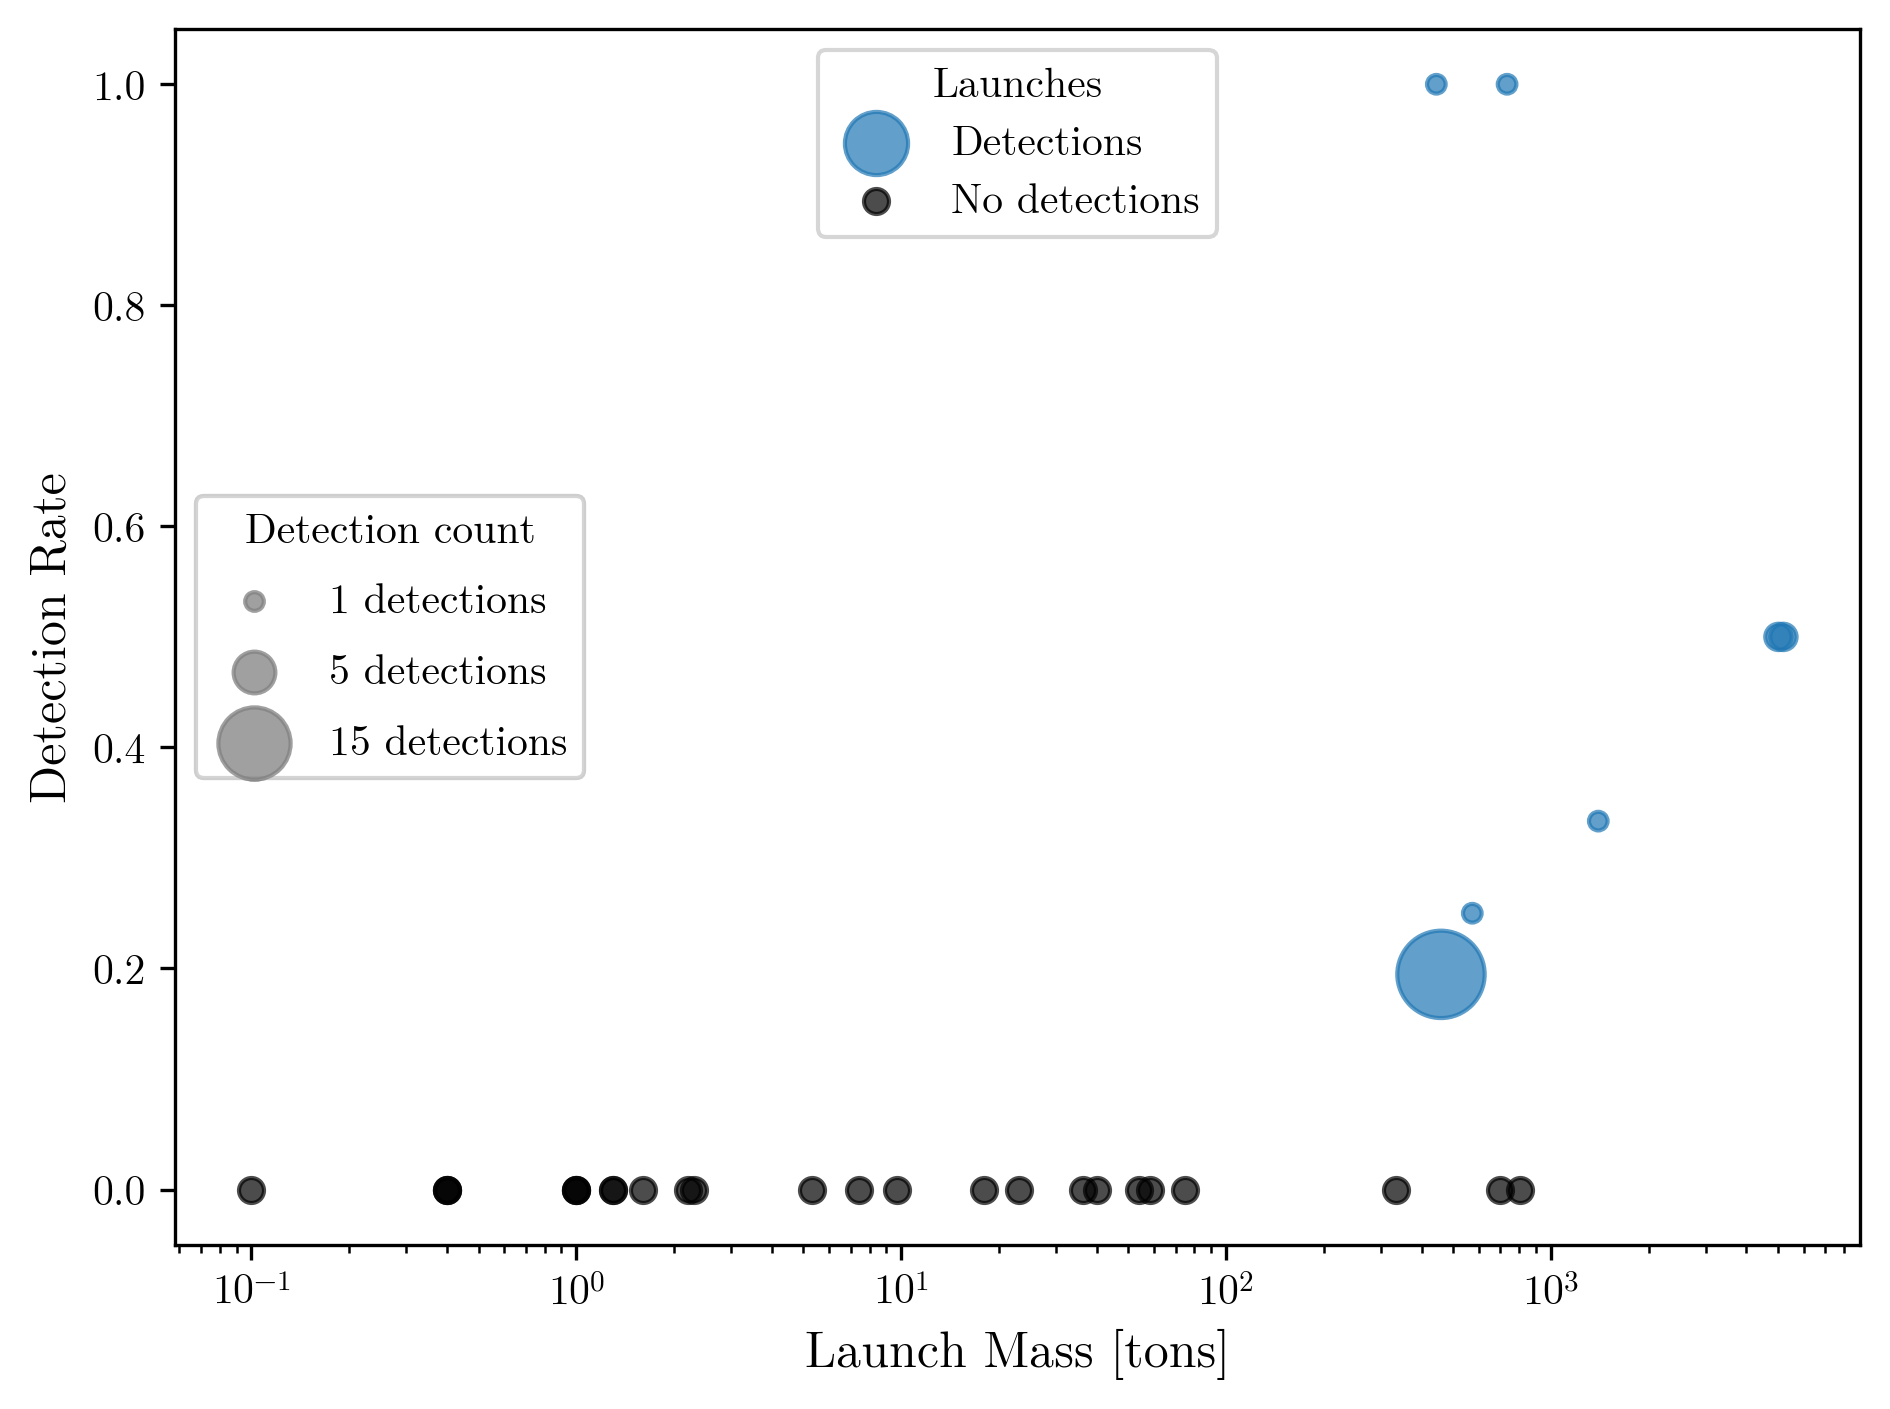

In [20]:
nondetections = plot_df[plot_df['detections'] == 0]
detections = plot_df[plot_df['detections'] > 0]

detections.sort_values('detection_rate', ascending=True)

fig, ax = plt.subplots(dpi=300)

# Main scatter plots
sc1 = ax.scatter(
    detections['Launch_Mass'],
    detections['detection_rate'],
    s=detections['detections'] * 20,
    alpha=0.7,
    label='Detections'
)
sc2 = ax.scatter(
    nondetections['Launch_Mass'],
    nondetections['detection_rate'],
    c='k',
    alpha=0.7,
    label='No detections'
)

ax.set_xlabel('Launch Mass [tons]', fontsize=12)
ax.set_ylabel('Detection Rate', fontsize=12)
ax.set_xscale('log')
color_legend = ax.legend(
    handles=[sc1, sc2],
    loc='upper center',
    title='Launches'
)
ax.add_artist(color_legend)  # Add this legend first so it doesn't get replaced

# --- Legend 2: Size legend ---
example_sizes = [1, 5, 15]
size_handles = [
    ax.scatter([], [], s=s * 20, c='gray', alpha=0.7)
    for s in example_sizes
]
size_labels = [f'{s} detections' for s in example_sizes]
size_legend = ax.legend(
    size_handles, size_labels,
    loc='center left',
    title='Detection count',
    scatterpoints=1,
    labelspacing=0.8 
)
ax.add_artist(size_legend)
# save figure

# vertical line at x=250
# ax.axvline(400, color='gray', linestyle='--', linewidth=1)


fig.tight_layout()
plt.savefig(f'figures/supfig_2.png', dpi=300)
plt.show()